<div align=center>

</div>

# QUBO Problems with MIMIQ

Copyright © 2024, QPefect. All rights Reserved.

## Installation

MIMIQ Circuits is compatible with Python 3.9 or later versions.

Here, MIMIQ Circuits is installed in the environment running the current Jupyter kernel.
The full installation, as shown here, includes visualization tools.

In [2]:
# !pip3 install "mimiqcircuits[visualization] @ git+https://github.com/qperfect-io/mimiqcircuits-python.git" > /dev/null

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try 'pacman -S
    python-xyz', where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Arch-packaged Python package,
    create a virtual environment using 'python -m venv path/to/venv'.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-Arch packaged Python application,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. Make sure you have python-pipx
    installed via pacman.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detailed specification.


## Importing MIMIQ Circuits

MIMIQ is a quantum computer simulation framework developed by QPerfect. The quantum circuit simulation capabilities of MIMIQ are included in the `mimiqcircuits-python` and `MimiqCircuits.jl` libraries, respectively, in Python and [Julia](https://julialang.org).

In [1]:
from mimiqcircuits import *

We import other libraries such as `numpy`, for linear algebra.

In [2]:
import numpy as np
from bitarray import bitarray, frozenbitarray
import matplotlib.pyplot as plt
import networkx as nx
import random

MIMIQ will attempt to connect with the remote services using the credentials stored in a `qperfect.json` file. If this is not possible, will attempt to recreate such file by opening a new window to ask for username and password for QPerfect remote services.

There are also other ways for connecting:

* `conn.connectUser("username", "password")` for login directly with creedentials
* `conn.connect()` for launching a webpage to insert username and passord.

In [3]:
conn = MimiqConnection()
try:
    conn.loadtoken()
except:
    conn.savetoken()
    conn.loadtoken()

Starting authentication server on port 1444 (http://localhost:1444)


127.0.0.1 - - [06/Jun/2024 16:03:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2024 16:03:09] "GET /assets/index-07679c1c.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2024 16:03:09] "GET /assets/index-3c66e04b.css HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2024 16:03:09] "GET /assets/index-07679c1c.js HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2024 16:03:09] "GET /assets/logo-141cb000.svg HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2024 16:03:09] "GET /assets/primeicons-3824be50.woff2 HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2024 16:03:09] "GET /favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [06/Jun/2024 16:03:55] "POST /api/login HTTP/1.1" 200 -


## Definitions of QUBO problem solvers

In [4]:
class QUBOProblem:
    def __init__(self, Q):
        if isinstance(Q, np.ndarray):
            if len(Q.shape) != 2 or Q.shape[0] != Q.shape[1]:
                raise ValueError("Q is not a valid square matrix.")
            self.Q = Q
        elif isinstance(Q, nx.Graph):
            self.Q = -nx.to_numpy_array(G)
        else:
            raise TypeError(f"Cannot build QUBO problem for object of type {typeof(Q)}")

    def _gamma(self, epsilon, lmbda, val):
        return epsilon * lmbda * val
        
    def _phaseseparator(self, c: Circuit, qubits, lmbda, epsilon):
        Q = self.Q
        for n in range(Q.shape[1]):
            for i in range(Q.shape[0]-n):
                j = i+n
                coeff1 = self.Q[i,j]
                gamma1 = self._gamma(epsilon, lmbda, coeff1)
                coeff2 = self.Q[j,i]
                gamma2 = self._gamma(epsilon, lmbda, coeff2)
                if i==j:
                    # diagonal elements
                    if gamma1 != 0:
                        c.push(GateP(gamma1), qubits[i])
                elif coeff1 == coeff2:
                    if gamma1 != 0:
                       c.push(GateCP(2*gamma1), qubits[i], qubits[j])
                else:
                    # general case!
                    if gamma1 != 0:
                        c.push(GateCP(gamma1), qubits[i], qubits[j])
                    if gamma2 != 0:
                        c.push(GateCP(gamma2), qubits[i], qubits[j])   
        return c

    def _mixer(self, c: Circuit, qubits, lmbda, epsilon):
    	c.push(GateRX(epsilon * (1 - lmbda)), qubits)
    	return c

    def _initstate(self, c: Circuit, qubits):
        # prepares the ground state of the mixer hamiltonian
        c.push(GateRY(np.pi / 2), qubits)
        return c

    def build_circuit(self, depth, epsilon=0.5):
        qubits = range(self.Q.shape[0])
        c = Circuit()
        self._initstate(c, qubits)
        for k in range(depth-1):
            lmbda = k / depth
            self._phaseseparator(c, qubits, lmbda, epsilon)
            self._mixer(c, qubits, lmbda, epsilon)
        self._phaseseparator(c, qubits, 1, epsilon)
        return c

    def energy(self, bss):
        if isinstance(bss, bitarray) or isinstance(bss, frozenbitarray):
            bbs = np.array(bss.tolist())
            return bbs.T @ self.Q @ bbs
            
        E = 0.0
        for bs in bss:
            bbs = np.array(bs.tolist())
            E += bbs.T @ self.Q @ bbs
        return E / len(bss)

    def _solve(self, conn, k, samples=1000, **kwargs):
        circ = self.build_circuit(k, **kwargs)
        job = conn.execute(circ, nsamples=samples)
        res = conn.get_results(job)
        E = self.energy(res.cstates)
        hist = res.histogram()
        mps = max(hist, key=lambda k: hist[k])
        return E, mps, res

    def solve(self, conn, k, samples=1000, **kwargs):
        E, mps, _ = self._solve(conn, k, samples=samples, **kwargs)
        return E, mps

    def solve_time(self, conn, k, samples=1000, **kwargs):
        E, mps, res = self._solve(conn, k, samples=samples, **kwargs)
        return E, mps, res.timings["total"]


# Digital adiabatic (QAOA-like) solver

The algorithm is made of three main pices:

* A system of qubits. One for every node in the graph.

* A mixing operator

$$
U^H_M(\beta) = \mathrm{e}^{-\imath \beta B}
\qquad
B = \sum_{j=1}^n X_j
$$

* A Phase separator, which encodes the details of the max cut problem

$$
U_P(\gamma) = \mathrm{e}^{-\imath \gamma H_P}
\qquad
H_P = -\sum_{\{u,v\} \in E} J_{uv} Z_u Z_v
$$

Here  $Z_i$ ($X_i$) are the pauli-$Z$ ($X$) rotations applied on qubit $i$, while $E$ is the set of edges of the graph, and $J_{uv}$ are the coefficients computed fror the QUBO problem.

First, we encode the problem such that the optimal solution is the ground state of $H_P$. Then we prepare the system in the ground state of the mixing operator (easy to do), and then we apply alternating $U_P(\gamma)$ and $U_M(\beta)$ terms, such that, the evolution of the initial state is:

$$
U_M(\beta_j) U_P(\gamma_j) \cdots U_M(\beta_1) U_P(\gamma_1) \ket{\psi}
$$

A simple choice for the parameters is:

* $\beta_j = 1 - \lambda_j$
* $\gamma_j = \lambda_j$
* $\lambda_j$ is a monotonic increasing function of $j$

With this choice, at every iteration we slowly "turn on" the hamiltonian $H_P$ while turning off $H_M$. For small enough steps, the algorithm will converge to the ground state of $H_p$.

## Example 1

Let's build a QUBO problem with 4 qubits.

Taken from  _Hadfield, S. et al. From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz. Algorithms 12, 34 (2019)_

In [5]:
Q = np.array([[-5,2,4,0],[2,-3,1,0],[4,1,-8,5],[0,0,5,-6]])
Q

array([[-5,  2,  4,  0],
       [ 2, -3,  1,  0],
       [ 4,  1, -8,  5],
       [ 0,  0,  5, -6]])

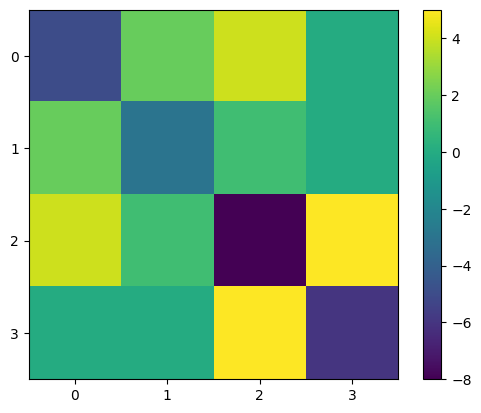

In [6]:
prob = QUBOProblem(Q)

# plot the problem
plt.imshow(prob.Q)
plt.xticks(range(prob.Q.shape[0]))
plt.yticks(range(prob.Q.shape[1]))
plt.colorbar()

The bitstring `1001` is the exact solution (with energy -11) of the QUBO problem.

In [7]:
prob.energy(bitarray("1001"))

-11

In [8]:
prob.solve(conn, 40)

(-10.723, frozenbitarray('1001'))

In [11]:
_, _, t = prob.solve_time(conn, 40)
print(f"Solved in {t} seconds")

Solved in 0.004302732 seconds


## Example 2

Let's build a QUBO problem with 8 qubits.

Taken from _Hadfield, S. et al. From the Quantum Approximate Optimization Algorithm to a Quantum Alternating Operator Ansatz. Algorithms 12, 34 (2019)_

In [9]:
Q8 = np.array([
    [-3525, 175, 325, 775, 1050, 425, 525, 250],
    [175, -1113, 91, 217, 294, 119, 147, 70],
    [325, 91, -1989, 403, 546, 221, 273, 130],
    [775, 217, 403, -4185, 1302, 527, 651, 310],
    [1050, 294, 546, 1302, -5208, 714, 882, 420],
    [425, 119, 221, 527, 714, -2533, 357, 170],
    [525, 147, 273, 651, 882, 357, -3045, 210],
    [250, 70, 130, 310, 420, 170, 210, -1560]
])

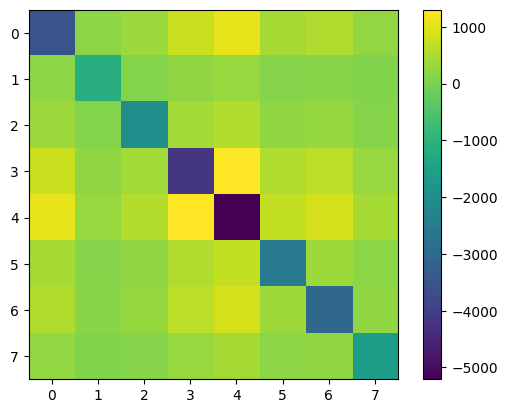

In [10]:
prob8 = QUBOProblem(Q8)

# plot the problem
plt.imshow(prob8.Q)
plt.xticks(range(prob8.Q.shape[0]))
plt.yticks(range(prob8.Q.shape[1]))
plt.colorbar()

In [11]:
prob8.energy(bitarray("00011001"))

-6889

In [14]:
prob8.solve(conn, 40)

(-5913.272, frozenbitarray('01111010'))

In [13]:
_, _, t = prob.solve_time(conn, 40)
print(f"Solved in {t} seconds")

Solved in 0.001960868 seconds
